## Exploration neurophys data for dyskinesia project

### Loading packages and functions, defining paths



In [438]:
# Importing Python and external packages
import os
import sys
import importlib
import json
from abc import ABCMeta, abstractmethod
from dataclasses import dataclass, field, fields
from collections import namedtuple
from typing import Any
from itertools import compress
from pathlib import Path
import pandas as pd
import numpy as np
import sklearn as sk
import scipy
import matplotlib.pyplot as plt
from scipy import signal

#mne
import mne_bids
import mne

# Models for py_nmd bids example
from sklearn import linear_model, metrics, model_selection

In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('mne_bids', mne_bids.__version__)
print('mne', mne.__version__)
print('sci-py', scipy.__version__)
print('sci-kit learn', sk.__version__)

Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
pandas 1.3.4
numpy 1.20.3
mne_bids 0.9
mne 0.24.1
sci-py 1.7.1
sci-kit learn 1.0.1


In [3]:
# define local storage directories
projectpath = '/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys'
datapath = os.path.join(projectpath, 'data/BIDS_Berlin_ECOG_LFP/rawdata')
codepath = os.path.join(projectpath, 'code')
figpath = os.path.join(projectpath, 'figures')
pynmd_path = os.path.join(codepath, 'py_neuromodulation')

# define external storage directories
ext_projectpath = '/Volumes/JH/Research/CHARITE/projects/dyskinesia_neurophys'
ext_datapath = os.path.join(ext_projectpath, 'data/BIDS_Berlin_ECOG_LFP/rawdata')


In [4]:
# import py_neuromodulation after defining relevant directories
os.chdir(pynmd_path)
print(os.getcwd())

from py_neuromodulation import nm_BidsStream, nm_analysis
import dyskinesia.preprocessing as preproc


/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code/py_neuromodulation


## I. Data Exploration and Preprocessing

### Ia. Selecting and loading in data via Data Classes in .py

- First DataClass defines which run/data-file should be used (via RunInfo)
- Second DataClass creates MNE-objects ordered by data-type (via RunRawData) 




Note that the resulting Data-Class Objects do not contain the actual data yet (!)
- Create RawBrainVision data-objects: load data with rawRun1.ecog.load_data() (incl. internal mne-functionality)
- Create np.array's: load data with rawRun1.ecog.get_data(), use return_times=True to return two tuples (data, times); (used in preprocessing.py functions)

In [758]:
# DEFINE PTATIENT-RUN SETTINGS
sub = '008'
ses = 'EphysMedOn02'
task = 'Rest'
acq = 'StimOffLD00'
run = '01'
sourcepath = ext_datapath

In [760]:
# create specific patient-run BIDS-Object for further pre-processing

# pm use later for json settings in pipeline
importlib.reload(preproc)
runInfo0 = preproc.RunInfo(
    sub=sub,
    ses=ses,
    task=task,
    acq=acq,
    run=run,
    sourcepath=sourcepath,
)
rawRun0 = preproc.RunRawData(bidspath=runInfo0.bidspath)

/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code/py_neuromodulation/dyskinesia/preprocessing.py:75: RuntimeWarning: Did not find any events.tsv associated with sub-008_ses-EphysMedOn02_task-Rest_acq-StimOffLD00_run-01.

The search_str was "/Volumes/JH/Research/CHARITE/projects/dyskinesia_neurophys/data/BIDS_Berlin_ECOG_LFP/rawdata/sub-008/**/ieeg/sub-008_ses-EphysMedOn02*events.tsv"
  self.bids = mne_bids.read_raw_bids(self.bidspath, verbose='WARNING')
/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code/py_neuromodulation/dyskinesia/preprocessing.py:75: RuntimeWarning: Defaulting coordinate frame to unknown from coordinate system input Other
  self.bids = mne_bids.read_raw_bids(self.bidspath, verbose='WARNING')
/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code/py_neuromodulation/dyskinesia/preprocessing.py:75: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  self.bids = m



------------ BIDS DATA INFO ------------
The raw-bids-object contains 47 channels with 2444946 datapoints and sample freq  4000.0 Hz
Bad channels are: ['LFP_L_16_STN_BS'] 

BIDS contains:
6 ECOG channels,
31 DBS channels: (15 left, 16 right), 
2 EMG channels, 
1 ECG channel(s), 
6 Accelerometry (misc) channels.




### Optional viewer for un-processed data with MNE's interactive viewer

In [68]:
# to load grouped BIDS-Objects:
# rawRun1.ecog.load_data()

# to visualize non-pre-processed data PSD's
# for interactive plotter: activate matplotlib qt line
# %matplotlib qt
# %matplotlib inline

# rawRun1.lfp_left.plot()
# rawRun1.lfp_left.plot_psd(n_fft=1024)
# rawRun1.ecog.plot_psd(n_fft=1024)

## Ib. Pre-processing


- Artefact search (manual-visual/ std dev check)
- Bandpass filter [1 - 100/120 Hz]
- Notchfilter (powerline 50, 100 Hz)
- Resampling (~ 250 Hz)
- Rereferencing


@re-referencing: hence all channels referenced against same channel.
Different contact surfaces lead to different impedances, requiring
different re-referencing -> try out different methods. Search for
best-practices in other groups.

In [787]:
# Define structures (namedtuples) to store Default settings
PreprocSettings = namedtuple('PreprocSettings', ('win_len artfct_sd_tresh'
                             ' bandpass_f transBW notchW Fs_orig Fs_resample'))
Settings = namedtuple('Settings', 'lfp_left lfp_right ecog')

In [788]:
default_lfp_settings = [.5, 3, (1, 120), 15, 3, 4000, 800]  # WORK IN PROGR
default_ecog_settings = [.5, 3, (1, 120), 10, 2, 4000, 800]

In [789]:
settings = Settings(
    PreprocSettings(*default_lfp_settings),
    PreprocSettings(*default_lfp_settings),
    PreprocSettings(*default_ecog_settings),
# '*' before lists unpacks the list-values as seperate args
)

In [ ]:
'''
INFO ON BIDS-RAW DATA STRUCTURES
-----
Grouped MNE BIDS Raw Object consists all channels within the group,
e.g. lfp_left, lfp_left, ecog, acc. Each channel (rawRun1.ecog[0])
is a tuple with the first object a ndarray of shape 1, N_samples.
Calling rawRun1.ecog[0][0] gives the ndarray containing only data-points.
Calling rawRun1.ecog[1] gives the ndarray containing the time stamps.
-----
'''

'\nINFO ON BIDS-RAW DATA STRUCTURES\n-----\nGrouped MNE BIDS Raw Object consists all channels within the group,\ne.g. lfp_left, lfp_left, ecog, acc. Each channel (rawRun1.ecog[0])\nis a tuple with the first object a ndarray of shape 1, N_samples.\nCalling rawRun1.ecog[0][0] gives the ndarray containing only data-points.\nCalling rawRun1.ecog[1] gives the ndarray containing the time stamps.\n-----\n\n'

In [800]:
for g in settings:
    print(g._name)
    print(g.win_len)

AttributeError: 'PreprocSettings' object has no attribute '_name'

In [ ]:
# Processing pre-proc steps in one Cell
importlib.reload(preproc)

for group in groups:
    
    # data_clean[group] = preproc.block_artefact_selection(
    #     bids_dict=data_raw,  # raw BIDS group to process
    #     group=group,
    #     win_len=.5,
    #     n_stds_cut=3,  # number of std-dev from mean that is used as cut-off
    #     save=os.path.join(figpath, 'preprocessing', runInfo0.store_str),  # folder to save fig
    # )
    # data_bp[group] = preproc.block_bp_filter(
    #     clean_dict=data_clean,
    #     group=group,
    #     sfreq=data_raw[group].info['sfreq'],
    #     l_freq=bandpass_f[0],
    #     h_freq=bandpass_f[1],
    # )
    # data_nf = {}
    # data_nf[group] = preproc.block_notch_filter(
    #     bp_dict=data_bp,
    #     group=group,
    #     transBW=15,  # based on figures for now: 10
    #     notchW=5,  # based on figures for now: 2
    #     save=os.path.join(figpath, 'preprocessing', runInfo0.store_str),  # folder to save fig
    #     verbose=False,
    # )

/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7044: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7044: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7044: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7044: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7044: RuntimeWarning: divide by zero encountered in lo

#### Artefact Removal (incl. Data Visualization)


For visualization inline vs in separate window figure, Run:
- %matplotlib inline, or:
- %matplotlib qt





In [695]:
# data_raw is filled with loaded mne-bids data per group
data_raw = {}
for field in rawRun1.__dataclass_fields__:
    # loops over variables within the data class
    if str(field)[:4] == 'lfp_':
        data_raw[str(field)] = getattr(rawRun1, field).load_data()
    elif str(field)[:4] == 'ecog':
        data_raw[str(field)] = getattr(rawRun1, field).load_data()

ch_names = {}
groups = ['lfp_left', 'lfp_right', 'ecog']
for group in groups:
    ch_names[group] = data_raw[group].info['ch_names']

In [712]:
# ARTEFACT REMOVAL per group (lfp-l/lfp-r/ecog)
groups = ['ecog', 'lfp_left', 'lfp_right']
# Run artefact removal per block  LFP
importlib.reload(preproc)
data_clean = {}
ch_nms = {}
for group in groups:
    data_clean[group], ch_nms[group] = preproc.block_artefact_selection(
        bids_dict=data_raw,  # raw BIDS group to process
        group=group,
        win_len=.5,
        n_stds_cut=3,  # number of std-dev from mean that is used as cut-off
        # to save: give directory, to show inline: give 'show', w/o fig: None
        save=os.path.join(figpath, 'preprocessing', runInfo0.store_str),  # folder to save fig
    )

START ARTEFACT REMOVAL: ecog
Ch 1: 0.0% is NaN (artefact or zero)
Ch 2: 1.88% is NaN (artefact or zero)
Ch 3: 0.0% is NaN (artefact or zero)
Ch 4: 0.0% is NaN (artefact or zero)
Ch 5: 1.15% is NaN (artefact or zero)
Ch 6: 0.0% is NaN (artefact or zero)
START ARTEFACT REMOVAL: lfp_left
Ch 1: 0.0% is NaN (artefact or zero)
Ch 2: 0.0% is NaN (artefact or zero)
Ch 3: 0.0% is NaN (artefact or zero)
Ch 4: 0.0% is NaN (artefact or zero)
Ch 5: 0.0% is NaN (artefact or zero)
Ch 6: 0.0% is NaN (artefact or zero)
Ch 7: 0.0% is NaN (artefact or zero)
Ch 8: 0.0% is NaN (artefact or zero)
Ch 9: 0.0% is NaN (artefact or zero)
Ch 10: 0.0% is NaN (artefact or zero)
Ch 11: 0.0% is NaN (artefact or zero)
Ch 12: 0.0% is NaN (artefact or zero)
Ch 13: 0.0% is NaN (artefact or zero)
Ch 14: 0.0% is NaN (artefact or zero)
Ch 15: 0.0% is NaN (artefact or zero)
START ARTEFACT REMOVAL: lfp_right
Ch 1: 0.41% is NaN (artefact or zero)
Ch 2: 100.0% is NaN (artefact or zero)
Ch 3: 22.5% is NaN (artefact or zero)
Ch 4

#### Bandpass Filtering

In [720]:
bandpass_f = (1, 120)  # tuple to set bandpass filter frequencies

In [722]:
importlib.reload(preproc)

data_bp = {}
for group in groups:
    data_bp[group] = preproc.block_bp_filter(
        clean_dict=data_clean,
        group=group,
        sfreq=data_raw[group].info['sfreq'],
        l_freq=bandpass_f[0],
        h_freq=bandpass_f[1],
    )

/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code/py_neuromodulation/dyskinesia/preprocessing.py:246: RuntimeWarning: filter_length (13201) is longer than the signal (2000), distortion is likely. Reduce filter length or filter a longer signal.
  sfreq=sfreq,
/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code/py_neuromodulation/dyskinesia/preprocessing.py:246: RuntimeWarning: filter_length (13201) is longer than the signal (2000), distortion is likely. Reduce filter length or filter a longer signal.
  sfreq=sfreq,
/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code/py_neuromodulation/dyskinesia/preprocessing.py:246: RuntimeWarning: filter_length (13201) is longer than the signal (2000), distortion is likely. Reduce filter length or filter a longer signal.
  sfreq=sfreq,
/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code/py_neuromodulation/dyskinesia/preprocessing.py:246: RuntimeWarning: filter_length (13

#### Notch-filtering for Powerline Noise

In [818]:
DataBandpassed = namedtuple('DataBandpassed', [*groups])

In [826]:
dataBandp = DataBandpassed(
    lfp_left=data_bp['lfp_left'],
    lfp_right=data_bp['lfp_right'],
    ecog=data_bp['ecog'],
)

In [833]:
# TODO MONDAY::::::
# DESIGN HOW TO STORE OUTCOME OF DATA FUNCTIONS ALSO AS ANMEDTUPLE ISTEAD OF DICT'S
DataNotched = namedtuple('DataNotched', 'lfp_left' )
notchtest = DataNotched(lfp_left=None)
notchtest.lfp_left = [3,4,4,4]
print(notchtest.lfp_left)

AttributeError: can't set attribute

In [852]:
# TODO MONDAY: find out optimal notch filter settings for LFP recordings
# start with 15, 5 (15, 3 is not sufficient)

In [482]:
# notch filtering in BLOCKS

# create tuples with transBW and notchW for ecog and lfp seperately
importlib.reload(preproc)
data_nf = {}
for datagroup in dataBandp._fields:
    data_nf[group] = preproc.block_notch_filter(
        bp_dict=dataBandp,  # NOT DICT ANYMORE MORE BUT NAMEDTUPLE!!!
        group=group,  # CALLS getattr() INSIDE FUNCTION WITH GROUP; CHANGE TO getattr() HERE??
        transBW=getattr(settings, group).transBW,  # based on figures for now: 10
        notchW=getattr(settings, group).notchW,  # based on figures for now: 2
        save=os.path.join(figpath, 'preprocessing', runInfo0.store_str),  # folder to save fig
        verbose=False,
    )

/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7044: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7044: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7044: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7044: RuntimeWarning: divide by zero encountered in log10
  line = self.plot(freqs, 10 * np.log10(pxx), **kwargs)
/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7044: RuntimeWarning: divide by zero encountered in lo

#### Resampling


Since freq's of interest are up to +/- 100 - 120 Hz, according to the Nyquist-theorem the max sample freq does not need to be more than double (~ 250 Hz).

Check differences with resampling to 400 or 800 Hz later. Or working with wider windows.
- Swann '16: 800 Hz
- Heger/ Herff: 600 Hz (https://www.csl.uni-bremen.de/cms/images/documents/publications/IS2015_brain2text.pdf)


In [493]:
data_nf.keys()

dict_keys(['lfp_right', 'lfp_left'])

In [37]:
# resampling one run at a time
aim_freq=800
orig_freq=4000
up=1
down=int(orig_freq / aim_freq)
ecog250 = signal.resample_poly(ecog_nfilt, up=up, down=down, axis=1)


In [379]:
rawRun1

RunRawData(bidspath=BIDSPath(
root: /Volumes/JH/Research/CHARITE/projects/dyskinesia_neurophys/data/BIDS_Berlin_ECOG_LFP/rawdata
datatype: ieeg
basename: sub-008_ses-EphysMedOn02_task-Rest_acq-StimOffLD00_run-01_ieeg.vhdr), bids=<RawBrainVision | sub-008_ses-EphysMedOn02_task-Rest_acq-StimOffLD00_run-01_ieeg.eeg, 47 x 2444946 (611.2 s), ~72 kB, data not loaded>, lfp=<RawBrainVision | sub-008_ses-EphysMedOn02_task-Rest_acq-StimOffLD00_run-01_ieeg.eeg, 31 x 2444946 (611.2 s), ~56 kB, data not loaded>, lfp_left=<RawBrainVision | sub-008_ses-EphysMedOn02_task-Rest_acq-StimOffLD00_run-01_ieeg.eeg, 15 x 2444946 (611.2 s), ~40 kB, data not loaded>, lfp_right=<RawBrainVision | sub-008_ses-EphysMedOn02_task-Rest_acq-StimOffLD00_run-01_ieeg.eeg, 16 x 2444946 (611.2 s), ~41 kB, data not loaded>, ecog=<RawBrainVision | sub-008_ses-EphysMedOn02_task-Rest_acq-StimOffLD00_run-01_ieeg.eeg, 6 x 2444946 (611.2 s), ~112.0 MB, data loaded>, acc=<RawBrainVision | sub-008_ses-EphysMedOn02_task-Rest_acq-Stim

In [387]:
# resample in blocks
# aim_freq=250  # frequency to become
# orig_freq=rawRun1.ecog.info['sfreq']  # original frequency
# up=1  # no upsampling
# down=int(orig_freq / aim_freq)  # ratio for downsampling
# # empty array to store resampled signals
# arr_250 = np.empty((arr_nfilt.shape[0], arr_nfilt.shape[1],
#                     int(arr_nfilt.shape[2] / down)))
# for w in np.arange(arr_nfilt.shape[0]):
#     # fill channel rows with resampled channel signals
#     arr_250[w, 1:, :] = signal.resample_poly(arr_nfilt[w, 1:, :], up=up, down=down, axis=1)
#     # fill time row with resampled time signal
#     arr_250[w, 0, :] = arr_nfilt[w, 0, 0:-1:down]

aim_freq=800  # frequency to become
orig_freq=rawRun1.ecog.info['sfreq']  # original frequency
up=1  # no upsampling
down=int(orig_freq / aim_freq)  # ratio for downsampling
# empty array to store resampled signals
arr_800 = np.empty((arr_nfilt.shape[0], arr_nfilt.shape[1],
                    int(arr_nfilt.shape[2] / down)))
for w in np.arange(arr_nfilt.shape[0]):
    # fill channel rows with resampled channel signals
    arr_800[w, 1:, :] = signal.resample_poly(arr_nfilt[w, 1:, :], up=up, down=down, axis=1)
    # fill time row with resampled time signal
    arr_800[w, 0, :] = arr_nfilt[w, 0, 0:-1:down]

#### Rereferencing


Relevant ECOG-rereferencing literature used: 
- Common Average Rereferencing (Liu ea, J Neural Eng 2015 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5485665/)
- ECOG is local sign with spread +/- 3mm (Dubey, J Neurosc 2019): https://www.jneurosci.org/content/39/22/4299 
- READ ON - DATA ANALYSIS: Relevance of data-driven spatial filtering for invasive EEG. For gamma: CAR is probably sufficient. For alpha-beta: ... Hihg inter-subject variability in ECOG. (Shaworonko & Voytek, PLOS Comp Biol 2021: https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009298)
- Submilimeter (micro)ECOG: http://iebl.ucsd.edu/sites/iebl.ucsd.edu/files/2018-06/Sub-millimeter%20ECoG%20pitch%20in%20human%20enables%20higher%20%EF%AC%81delity%20cognitiveneural%20state%20estimation.pdf


Check rereferencing methods:
- de Cheveigne/Arzounian NeuroImage 2018
- pre-prints Merk 2021 and Petersen 2021 (AG Kühn / AG Neumann)
- pre-print epilepsy ecog movement (MUMC)


P.M. Check further in to Spatial Filtering:
- Spatial filter estimation via spatio-spectral decomposition: ............ TO READ   (Nikulin & Curio, NeuroImage 2011, https://www.sciencedirect.com/science/article/pii/S1053811911000930?via%3Dihub)
- Spatio-Spectral Decomposition: proposed dimensionality-reduction instead of PCA (Haufe, ..., Nikulin, https://www.sciencedirect.com/science/article/pii/S1053811914005503?via%3Dihub)


(2000,)

In [419]:
# simple Common Average Rereferening per window
arr_reref = np.empty(arr_nfilt.shape)
sig_chs = np.arange(1, arr_nfilt.shape[1])
for w in np.arange(arr_nfilt.shape[0]):
    arr_reref[w, 0, :] = arr_nfilt[w, 0, :]
    for ch in sig_chs:
        ref_chs = list(sig_chs)
        ref_chs.remove(ch)
        ref_mean = np.mean(arr_nfilt[w, ref_chs, :], axis=0)
        arr_reref[0, ch, :] = arr_nfilt[0, ch, :] - ref_mean

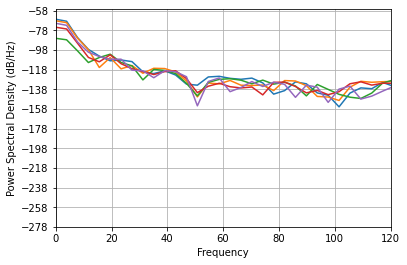

In [417]:
for c in np.arange(1,6):
    plt.psd(arr_reref[0, c, :], Fs=4000, NFFT=1024)
plt.xlim(0, 120)
plt.show()

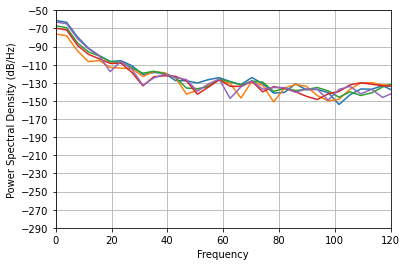

In [418]:
for c in np.arange(1,6):
    plt.psd(arr_nfilt[0, c, :], Fs=4000, NFFT=1024)
plt.xlim(0, 120)
plt.show()

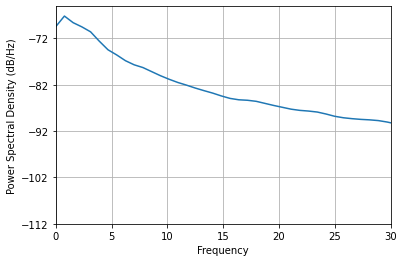

In [391]:
plt.psd(arr_800[200, 3, :], Fs=800, NFFT=1024)
plt.xlim(0, 30)
plt.show()

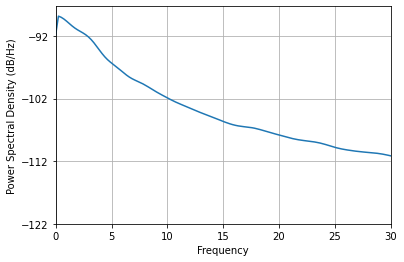

In [368]:
plt.psd(arr_250[200, 3, :], Fs=250, NFFT=1024)
plt.xlim(0, 30)
plt.show()

In [187]:
arr_3d = np.zeros((int(n_wins), arr.shape[0], win_len))
for w, i in enumerate(np.arange(0, arr.shape[1], win_len)[:-1]):
    arr_3d[w, :, :] = arr[:, i:i + win_len]

## Signal Processing


<b> Periodic component analysis: </b> 
- Try Wavelet Dceomposition vs Welch (tapered) Spectral Decomposition



<b> Aperiodic estimates </b>
Relevant literature:
- Periodic and a-periodic components relevance and interaction, different reasons (per + a-per) for signal changes observed within a specific bandwidth. Aperiodic component (complicated) vs exponent (1/f) (Donoghue, ..., Shestyuk & Voytek, Nature Neurosc 2020 : https://www.nature.com/articles/s41593-020-00744-x)
- cycle-by-cycle features: bycycle toolbox (Cole & Voytek, J of Neurophys 2019, https://journals.physiology.org/doi/full/10.1152/jn.00273.2019)

In [351]:
# APERIODIC EXPONENT
from fooof import FOOOF  # https://fooof-tools.github.io/fooof/

# cycle-by-cyle estimates
# neurodsp == 1.0.0  # install/import
# # neurodsp is a toolbox for digital signal processing for neural time series
# bycycle == 0.1.3  # install/import
# # bycycle is a toolbox for cycle-by-cycle analyses of neural oscillations

In [79]:
f, psd = signal.welch(
x=ecog250[3][0:125],
fs=250,
window='hann',
nperseg=125,
noverlap=None,
nfft=F,
)

psd.shape

(513,)

In [95]:
t = np.array(psd)
print(t.shape)
t = np.append(t, psd, axis=0)
print(t.shape)
t = np.append(t, psd, axis=0)
t = np.append(t, psd, axis=0)
t = np.resize(t, [4, 513])
print(t.shape)
t = np.mean(t, axis=0)
print(t.shape)


(513,)
(1026,)
(4, 513)
(513,)


In [106]:
t.shape

(513,)

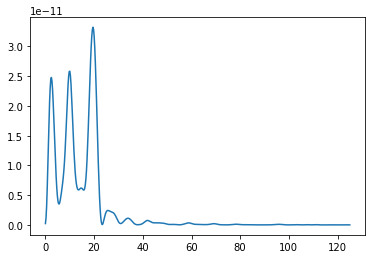

In [104]:
plt.plot(f, t,)


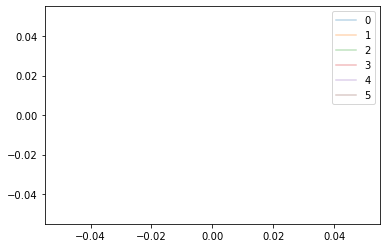

In [63]:
# visual checking
for C in np.arange(ecog250.shape[0]):  # loop over diff channels
    # for S in np.arange(10):
    f, psd = signal.welch(
        x=ecog250[C],
        fs=250,
        window='hann',
        nperseg=250,
        noverlap=None,
        nfft=250,
    )
    plt.plot(f, psd, label=C, alpha=.3)    
        # plt.psd(ecog250[4, int(0 * S):int(125 * S)],
        #     Fs=250, NFFT=1024, label=S, alpha=.3)
plt.legend()
plt.show()

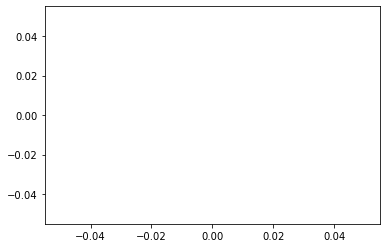

In [187]:
f, psd = signal.welch(
    x=ecog250,
    fs=250,
    window='hann',
    nperseg=512,
    noverlap=None,
    nfft=1024,
)
plt.plot(f, psd.T)

[]

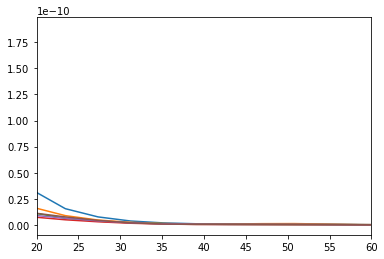

In [26]:
plt.plot(f, psd.T)
plt.xlim(20, 60)
# plt.ylim(0, 0.4)
plt.plot()

In [516]:
# mne preprocess functionaility
# dir(mne.preprocessing)

# mne functions to check
# raw = mne.set_eeg_reference(raw, ref_channels='average', ch_type='ecog')[0]
# raw = raw.resample(sfreq=500)
# freqs = np.arange(50, raw.info['sfreq'] / 2, 50)
# raw = raw.notch_filter(freqs)

In [567]:
x2.plot_psd()

AttributeError: 'numpy.ndarray' object has no attribute 'plot_psd'

In [545]:
# Downsampling (mne using scipy.signal.resample)
x = d1[d1.ch_names[0]][0][0]
# sample from 4000 to 800: 2.5 factor down
x2 = mne.filter.resample(x, down=2.5, npad='auto')  # test different window values


In [564]:

# notch-filter for power line noise
linefreq = d1.info['line_freq']  # 50 Hz
frqs = np.arange(linefreq, 801, linefreq)
dfilt = d1.notch_filter(
    frqs, picks='data', method='fir',
    # notch_widths=3,
    # trans_bandwidth=15
)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 26401 samples (6.600 sec)



Effective window size : 0.512 (s)


/var/folders/7d/4ptht2m910d1y872jrgp9cq40000gp/T/ipykernel_20832/2061118315.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  d1.plot_psd()


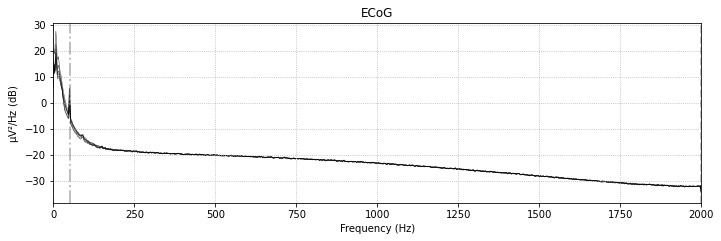

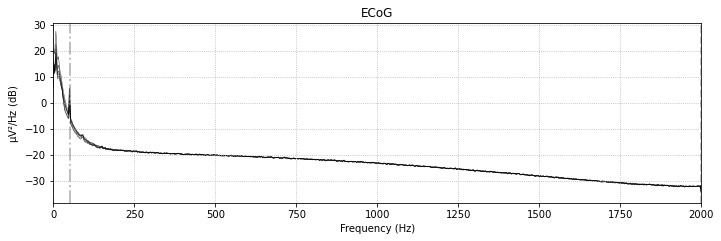

In [81]:
d1.plot_psd()

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 1761 samples (0.440 sec)

Effective window size : 0.512 (s)


/var/folders/7d/4ptht2m910d1y872jrgp9cq40000gp/T/ipykernel_41627/86534891.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  ecog.plot_psd(fmax=200)


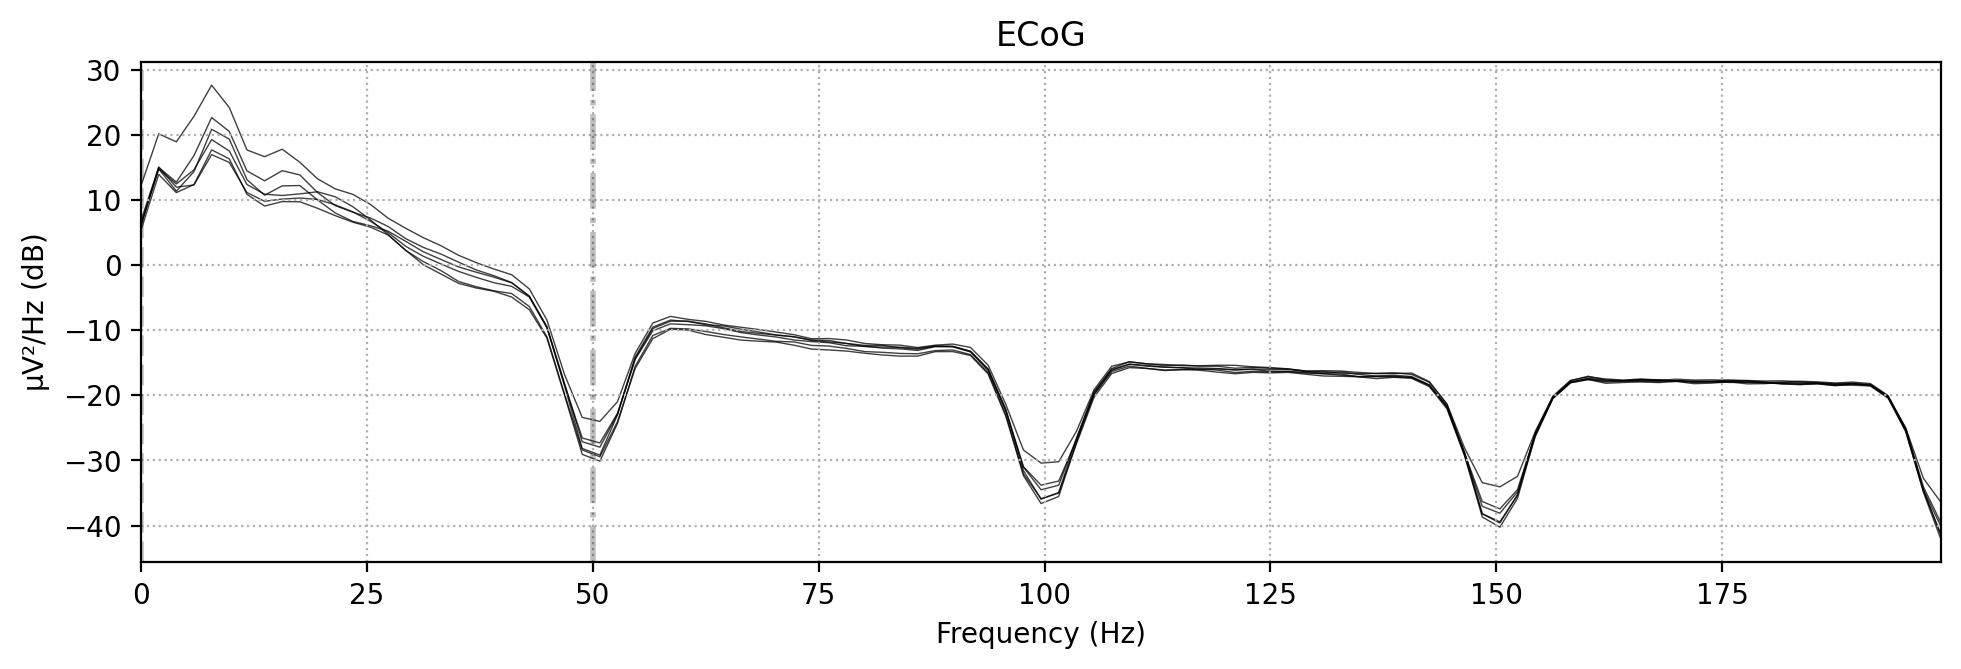

In [300]:
ecog = ecog.notch_filter(
    frqs, picks='data', method='fir',
    notch_widths=3,
    trans_bandwidth=15
)
ecog.plot_psd(fmax=200)

#### - Annotations and Events

In [ ]:
# check:
events, event_id = mne.events_from_annotations(raw, event_id={"EMG_onset": 1})
epochs = mne.Epochs(raw, events=events, tmin=-5, tmax=5, baseline=None)

#### - Feature extraction and visualization

In [ ]:
freqs = np.arange(1, 100)
n_cycles = 5

In [ ]:
power = mne.time_frequency.tfr_morlet(
    epochs, 
    freqs=freqs, 
    n_cycles=n_cycles, 
    return_itc=False, 
    picks='ecog', 
    n_jobs=-1
)

In [ ]:
power.ch_names

In [ ]:
%matplotlib inline
power.plot(
    cmap="viridis", 
    baseline=(-3, 3), 
    mode="zscore", 
    tmin=-3, 
    tmax=3., 
    vmin=-3, 
    vmax=3.
)

### II. Data analysis using py_neuromodulation

#### IIa. Defining and Loading Data



In [ ]:
# define details of run of interest
pt = '008'
ses = 'EphysMedOn02'
task = 'Rest'
acq = 'StimOffLD00'
run = '01'
filename = f'sub-{pt}_ses-{ses}_task-{task}_acq-{acq}_run-{run}_ieeg.vhdr'

# py_nmd paths for sub-008 and specific file
pathbids = ext_datapath
pathrun = os.path.join(pathbids, f'sub-{pt}/ses-{ses}/ieeg/{filename}')
pathout = os.path.join(projectpath, f'data/derivatives/sub-{pt}')

In [39]:
'''
Setting up Bids-Stream of data to use for feature extraction
- Settings have to be defined in nm_settings.json (redirect with PATH_SETTINGS attr)
- e.g. time selection via LIMIT_DATA=True and 
'''

# # check settings from json
# nm_BidsStream.BidsStream?
# pn_stream.PATH_SETTINGS

print(pathrun)
pn_stream = nm_BidsStream.BidsStream(
    PATH_RUN=pathrun,
    PATH_BIDS=pathbids,
    PATH_OUT=pathout, 
    PATH_SETTINGS=os.path.join(pynmd_path, 'dyskinesia/nm_settings.json')
)
# internal conversion of filename in bidsStream


/Volumes/JH/Research/CHARITE/projects/dyskinesia_neurophys/data/BIDS_Berlin_ECOG_LFP/rawdata/sub-008/ses-EphysMedOn02/ieeg/sub-008_ses-EphysMedOn02_task-Rest_acq-StimOffLD00_run-01_ieeg.vhdr
No Error occurred when testing the settings.
Extracting parameters from /Volumes/JH/Research/CHARITE/projects/dyskinesia_neurophys/data/BIDS_Berlin_ECOG_LFP/rawdata/sub-008/ses-EphysMedOn02/ieeg/sub-008_ses-EphysMedOn02_task-Rest_acq-StimOffLD00_run-01_ieeg.vhdr...
Setting channel info structure...
Reading channel info from /Volumes/JH/Research/CHARITE/projects/dyskinesia_neurophys/data/BIDS_Berlin_ECOG_LFP/rawdata/sub-008/ses-EphysMedOn02/ieeg/sub-008_ses-EphysMedOn02_task-Rest_acq-StimOffLD00_run-01_channels.tsv.
Reading in coordinate system frame Other: None.
Reading electrode coords from /Volumes/JH/Research/CHARITE/projects/dyskinesia_neurophys/data/BIDS_Berlin_ECOG_LFP/rawdata/sub-008/ses-EphysMedOn02/ieeg/sub-008_ses-EphysMedOn02_electrodes.tsv.


/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code/py_neuromodulation/py_neuromodulation/nm_IO.py:41: RuntimeWarning: Did not find any events.tsv associated with sub-008_ses-EphysMedOn02_task-Rest_acq-StimOffLD00_run-01.

The search_str was "/Volumes/JH/Research/CHARITE/projects/dyskinesia_neurophys/data/BIDS_Berlin_ECOG_LFP/rawdata/sub-008/**/ieeg/sub-008_ses-EphysMedOn02*events.tsv"
  raw_arr = mne_bids.read_raw_bids(bids_path)
/Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/code/py_neuromodulation/py_neuromodulation/nm_IO.py:41: RuntimeWarning: Defaulting coordinate frame to unknown from coordinate system input Other
  raw_arr = mne_bids.read_raw_bids(bids_path)
--- Logging error ---
Traceback (most recent call last):
  File "/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/Users/jeroenhabets/anaconda3/envs/ecog_dysk/lib/python3.9/logging/__init__.py", li

No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 7.50 Hz
- Upper transition bandwidth: 7.50 Hz
- Filter length: 999 samples (0.999 sec)



In [40]:
'''
to check and select channels:
- shows which channels are included for feature extraction (default is ECOG)
- change manually: pn_stream.nm_channels.at[ROWNR, 'used'] = 0 / 1, see next cell
'''
pn_stream.nm_channels



,name,rereference,used,target,type,status,new_name
0,LFP_R_1_STN_BS,LFP_R_16_STN_BS,0,0,dbs,good,LFP_R_1_STN_BS-LFP_R_16_STN_BS
1,LFP_R_2_STN_BS,LFP_R_1_STN_BS,0,0,dbs,good,LFP_R_2_STN_BS-LFP_R_1_STN_BS
2,LFP_R_3_STN_BB,LFP_R_2_STN_BS,0,0,dbs,good,LFP_R_3_STN_BB-LFP_R_2_STN_BS
3,LFP_R_4_STN_BS,LFP_R_3_STN_BB,0,0,dbs,good,LFP_R_4_STN_BS-LFP_R_3_STN_BB
4,LFP_R_5_STN_BS,LFP_R_4_STN_BS,0,0,dbs,good,LFP_R_5_STN_BS-LFP_R_4_STN_BS
5,LFP_R_6_STN_BS,LFP_R_5_STN_BS,0,0,dbs,good,LFP_R_6_STN_BS-LFP_R_5_STN_BS
6,LFP_R_7_STN_BS,LFP_R_6_STN_BS,0,0,dbs,good,LFP_R_7_STN_BS-LFP_R_6_STN_BS
7,LFP_R_8_STN_BS,LFP_R_7_STN_BS,0,0,dbs,good,LFP_R_8_STN_BS-LFP_R_7_STN_BS
8,LFP_R_9_STN_BS,LFP_R_8_STN_BS,0,0,dbs,good,LFP_R_9_STN_BS-LFP_R_8_STN_BS
9,LFP_R_10_STN_BS,LFP_R_9_STN_BS,0,0,dbs,good,LFP_R_10_STN_BS-LFP_R_9_STN_BS


In [81]:
# define row numbers to in- and exclude
channelsIn = [1, 2, 5, 6]
channelsOut = [3, np.arange(10, 16)]

for r in channelsIn : pn_stream.nm_channels.at[r, 'used'] = 1
for r in channelsOut : pn_stream.nm_channels.at[r, 'used'] = 0

# check whether result is correct
# pn_stream.nm_channels


In [82]:
pn_stream.settings

{'out_path': 'C:\\Users\\ICN_admin\\Documents\\py_neuromodulation\\examples\\rt_example',
 'sampling_rate_features': 10,
 'methods': {'raw_resampling': True,
  'raw_normalization': False,
  'feature_normalization': True,
  'kalman_filter': True,
  're_referencing': True,
  'notch_filter': True,
  'bandpass_filter': False,
  'stft': True,
  'fft': False,
  'raw_hjorth': True,
  'sharpwave_analysis': True,
  'return_raw': True,
  'project_cortex': False,
  'project_subcortex': False,
  'coherence': False},
 'raw_resampling_settings': {'resample_freq': 1000},
 'raw_normalization_settings': {'normalization_time': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'feature_normalization_settings': {'normalization_time': 30,
  'normalization_method': 'zscore',
  'clip': 3},
 'kalman_filter_settings': {'Tp': 0.1,
  'sigma_w': 0.7,
  'sigma_v': 1,
  'frequency_bands': ['theta',
   'alpha',
   'low beta',
   'high beta',
   'low gamma',
   'high gamma',
   'HFA']},
 'stft_settings': {'windo

In [83]:

pn_stream.run_bids()

_SIDECAR.json saved to /Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/data/derivatives/sub-003_ses-EphysMedOn03_task-Rest_acq-StimOff_run-01_ieeg/sub-003_ses-EphysMedOn03_task-Rest_acq-StimOff_run-01_ieeg_SIDECAR.json
FEATURES.csv saved to /Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/data/derivatives/sub-003_ses-EphysMedOn03_task-Rest_acq-StimOff_run-01_ieeg/sub-003_ses-EphysMedOn03_task-Rest_acq-StimOff_run-01_ieeg_FEATURES.csv
settings.json saved to /Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/data/derivatives/sub-003_ses-EphysMedOn03_task-Rest_acq-StimOff_run-01_ieeg/sub-003_ses-EphysMedOn03_task-Rest_acq-StimOff_run-01_ieeg_SETTINGS.json
nm_channels.csv saved to /Users/jeroenhabets/Research/CHARITE/projects/dyskinesia_neurophys/data/derivatives/sub-003_ses-EphysMedOn03_task-Rest_acq-StimOff_run-01_ieeg/sub-003_ses-EphysMedOn03_task-Rest_acq-StimOff_run-01_ieeg_nm_channels.csv


In [84]:
feat_arr = pn_stream.feature_arr

In [85]:
feat_arr

,ECOG_L_1_SMC_AT-avgref_RawHjorth_Activity,ECOG_L_1_SMC_AT-avgref_RawHjorth_Mobility,ECOG_L_1_SMC_AT-avgref_RawHjorth_Complexity,ECOG_L_1_SMC_AT-avgref_raw,ECOG_L_1_SMC_AT-avgref_Sharpwave_Max_prominence,ECOG_L_1_SMC_AT-avgref_Sharpwave_Mean_interval,ECOG_L_1_SMC_AT-avgref_Sharpwave_Max_sharpness,ECOG_L_1_SMC_AT-avgref_stft_theta,ECOG_L_1_SMC_AT-avgref_stft_alpha,ECOG_L_1_SMC_AT-avgref_stft_low beta,...,ECOG_L_6_SMC_AT-avgref_Sharpwave_Mean_interval,ECOG_L_6_SMC_AT-avgref_Sharpwave_Max_sharpness,ECOG_L_6_SMC_AT-avgref_stft_theta,ECOG_L_6_SMC_AT-avgref_stft_alpha,ECOG_L_6_SMC_AT-avgref_stft_low beta,ECOG_L_6_SMC_AT-avgref_stft_high beta,ECOG_L_6_SMC_AT-avgref_stft_low gamma,ECOG_L_6_SMC_AT-avgref_stft_high gamma,ECOG_L_6_SMC_AT-avgref_stft_HFA,time
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1000.0
1,1.000000,-1.000000,1.000000,-1.000000,-1.000000,NaN,1.000000,-1.000000,-1.000000,-1.000000,...,NaN,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1100.0
2,1.249855,-1.347821,1.400421,0.845474,0.211719,NaN,-0.220223,-0.920569,-0.956727,-0.944672,...,NaN,-0.976045,-0.947026,-0.947052,-0.941502,-0.955038,-0.948524,-0.956315,-0.955510,1200.0
3,1.111725,-1.220956,1.474828,-0.945201,0.247987,NaN,0.067416,-0.581214,-0.628032,-0.624115,...,NaN,-1.033631,-0.649040,-0.628319,-0.593958,-0.652923,-0.645195,-0.667222,-0.667057,1300.0
4,0.679086,-0.963092,1.286977,1.235327,-0.477227,NaN,0.176255,0.018557,-0.034150,-0.060021,...,NaN,0.185399,-0.088966,-0.057889,0.011162,-0.066580,-0.103084,-0.148577,-0.147408,1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6005,2.205366,-1.159219,-0.553578,0.143457,1.589451,1.0,-0.835619,1.444212,1.536644,1.578707,...,-0.678504,0.772299,1.791214,1.613632,1.098227,-1.091285,-0.257122,1.705658,2.499353,601500.0
6006,1.736325,-0.949351,-0.959076,1.727164,2.199940,1.0,-0.732693,1.385442,1.575145,1.492909,...,-0.100548,1.232483,1.702876,1.554317,0.851716,-1.141840,-0.455224,1.585663,2.352783,601600.0
6007,1.600621,-0.884826,-0.807259,0.011312,0.120433,1.0,-1.622148,1.303087,1.502319,1.453259,...,-0.596033,-0.021401,1.566366,1.319087,0.673340,-1.034572,-0.881800,1.334478,1.927903,601700.0
6008,1.781072,-1.032723,-0.910633,1.151224,1.857048,1.0,-1.069028,1.250598,1.491126,1.464359,...,0.479125,1.264149,1.331299,1.204932,0.620067,-0.975593,-1.147584,1.097782,1.760505,601800.0


In [179]:
selword = 'beta' #'LFP_L_234_STN_'  # raw
sellist = list(compress(feat_arr.keys(), [ selword in k for k in feat_arr.keys()]))
print(f'Nr features containing {selword}: {len(sellist)}\n {sellist}')

Nr features containing beta: 64
 ['ECOG_L_1_SMC_AT-avgref_stft_low beta', 'ECOG_L_1_SMC_AT-avgref_stft_high beta', 'ECOG_L_2_SMC_AT-avgref_stft_low beta', 'ECOG_L_2_SMC_AT-avgref_stft_high beta', 'ECOG_L_3_SMC_AT-avgref_stft_low beta', 'ECOG_L_3_SMC_AT-avgref_stft_high beta', 'ECOG_L_4_SMC_AT-avgref_stft_low beta', 'ECOG_L_4_SMC_AT-avgref_stft_high beta', 'ECOG_L_5_SMC_AT-avgref_stft_low beta', 'ECOG_L_5_SMC_AT-avgref_stft_high beta', 'ECOG_L_6_SMC_AT-avgref_stft_low beta', 'ECOG_L_6_SMC_AT-avgref_stft_high beta', 'LFP_L_1_STN_BS-LFP_L_567_STN_BS_stft_low beta', 'LFP_L_1_STN_BS-LFP_L_567_STN_BS_stft_high beta', 'LFP_L_234_STN_BS-LFP_L_1_STN_BS_stft_low beta', 'LFP_L_234_STN_BS-LFP_L_1_STN_BS_stft_high beta', 'LFP_L_567_STN_BS-LFP_L_234_STN_BS_stft_low beta', 'LFP_L_567_STN_BS-LFP_L_234_STN_BS_stft_high beta', 'LFP_R_234_STN_BS-LFP_R_567_STN_BS_stft_low beta', 'LFP_R_234_STN_BS-LFP_R_567_STN_BS_stft_high beta', 'LFP_R_567_STN_BS-LFP_R_234_STN_BS_stft_low beta', 'LFP_R_567_STN_BS-LFP_R_2

In [70]:
# plt.plot(feat_arr['LFP_L_234_STN_BS-LFP_L_1_STN_BS_RawHjorth_Activity'][1:])
# plt.plot(feat_arr['ECOG_L_6_SMC_AT-avgref_raw'][1:], alpha=.5)

In [107]:
filename = os.path.basename(pathrun)  # gives only filename
feature_reader = nm_analysis.Feature_Reader(
    feature_dir=pathout,
    feature_file=filename
)

In [108]:
ch = "ECOG_L_1_SMC_AT-avgref"
list_feature_keywords = ["stft"]

In [71]:
# feature_reader.plot_target_averaged_channel(
#     ch=ch,
#     list_feature_keywords=list_feature_keywords,
#     epoch_len=4,  # doesnt run with different epoch-length
#     threshold=.5
# )


In [115]:
model = linear_model.LogisticRegression(class_weight='balanced')


In [116]:
feature_reader.set_decoder(
        model = model,
        eval_method=metrics.balanced_accuracy_score,
        cv_method=model_selection.KFold(n_splits=3, shuffle=True),
        get_movement_detection_rate=True,
        min_consequent_count=2
    )

In [117]:
performances = feature_reader.run_ML_model(
        estimate_channels=True,
        estimate_gridpoints=True,
        estimate_all_channels_combined=False,
        save_results=True
)

no movements in label
no movements in label
model being saved to: /Users/jeroenhabets/Research/CHARITE/projects/retune_dyskinesia/code/py_neuromodulation_0_01/examples/data/derivatives/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_ieeg/sub-testsub_ses-EphysMedOff_task-buttonpress_run-0_ieeg_LM_ML_RES.p


In [72]:
# feature_reader.plot_subject_grid_ch_performance(performance_dict=performances, plt_grid=True)

### FeatureEstimationDemo

In [142]:
# featureEstimation example
import matplotlib.pyplot as plt

# first specify path to get example folder, second py_neuromodulation folder
PATH_PYNEUROMODULATION = Path("__file__").absolute().parent.parent  # "__file__" required for ipynb
sys.path.append(os.path.join(PATH_PYNEUROMODULATION))

PATH_PYNEUROMODULATION

# from pyneuromodulation import nm_start_BIDS, nm_settings, nm_IO, nm_define_nmchannels, nm_features
#                             #   nm_generator, nm_rereference, nm_resample, nm_run_analysis, nm_normalization, nm_projection
'''
nm_start_BIDS, nm_settings, nm_IO, ..., not present py-files in pyneuromodulation
start_BIDS, settings, IO are available as .txt-files
'''

'\nnm_start_BIDS, nm_settings, nm_IO, ..., not present py-files in pyneuromodulation\nstart_BIDS, settings, IO are available as .txt-files\n'

In [136]:
os.getcwd()

'/Users/jeroenhabets/Research/CHARITE/projects/retune_dyskinesia/code/py_neuromodulation_0_01'